<a href="https://colab.research.google.com/github/NancyBiyahut/intrusion-detection-autoencoder/blob/main/LSTMautoencoder_services(top_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [3]:
df= pd.read_csv('kdd_train1.csv')
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
service_values = df['service'].unique()
print(service_values)

['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784']


In [59]:
column_name = 'service'
# Count the occurrences of each unique value in the column
value_counts = df[column_name].value_counts()
# Calculate the total number of entries in the column
total_entries = df[column_name].count()
# Calculate the occupancy percentage for each unique value
occupancy_percentage = (value_counts / total_entries) * 100
top_values = occupancy_percentage.head(10)
selected_services = [ value for value , percentage in top_values.items()]
print(top_values)
print(selected_services)

service
http        31.744676
private     17.566371
domain_u     7.148960
smtp         5.781927
ftp_data     5.477452
eco_i        3.669240
other        3.400494
ecr_i        2.428037
telnet       1.941808
finger       1.370140
Name: count, dtype: float64
['http', 'private', 'domain_u', 'smtp', 'ftp_data', 'eco_i', 'other', 'ecr_i', 'telnet', 'finger']


In [62]:
column_name = 'service'

# Count the occurrences of each unique value in the column
value_counts = df[column_name].value_counts()

# Calculate the total number of entries in the column
total_entries = df[column_name].count()

# Calculate the occupancy percentage for each unique value
occupancy_percentage = (value_counts / total_entries) * 100

# Get the top 10 values by occupancy percentage
top_values = occupancy_percentage.head(10)

selected_services = [value for value, percentage in top_values.items()]

print("Top Values:")
print(top_values)
print("\nSelected Services:")
print(selected_services)

# Calculate the percentage of occurrences where the 'label' field is not 'normal' for each top value
non_normal_percentage = []
for value in selected_services:
    non_normal_count = df[(df[column_name] == value) & (df['labels'] != 'normal')].shape[0]
    total_non_normal_count = df[df['labels'] != 'normal'].shape[0]
    if total_non_normal_count != 0:
        non_normal_percentage.append((non_normal_count / total_non_normal_count) * 100)
    else:
        non_normal_percentage.append(0)

print("\nPercentage of occurrences where 'labels' field is not 'normal' for each top value:")
for i in range(len(selected_services)):
    print(f"{selected_services[i]}: {non_normal_percentage[i]:.2f}%")


Top Values:
service
http        31.744676
private     17.566371
domain_u     7.148960
smtp         5.781927
ftp_data     5.477452
eco_i        3.669240
other        3.400494
ecr_i        2.428037
telnet       1.941808
finger       1.370140
Name: count, dtype: float64

Selected Services:
['http', 'private', 'domain_u', 'smtp', 'ftp_data', 'eco_i', 'other', 'ecr_i', 'telnet', 'finger']

Percentage of occurrences where 'labels' field is not 'normal' for each top value:
http: 3.83%
private: 35.75%
domain_u: 0.02%
smtp: 0.47%
ftp_data: 3.28%
eco_i: 7.00%
other: 2.92%
ecr_i: 4.85%
telnet: 2.47%
finger: 2.00%


In [13]:
df= pd.read_csv('kdd_train1.csv')
data=df.copy()
categorical_features=[feature for feature in  df.columns if data[feature].dtypes=='O']
categorical_features

['protocol_type', 'service', 'flag', 'labels']

In [ ]:
#selected_services = ['ftp_data', 'http', 'ssh', 'smtp', 'telnet', 'dns', 'netbios']

In [15]:
df_http = df[df['service'].isin(selected_services)]

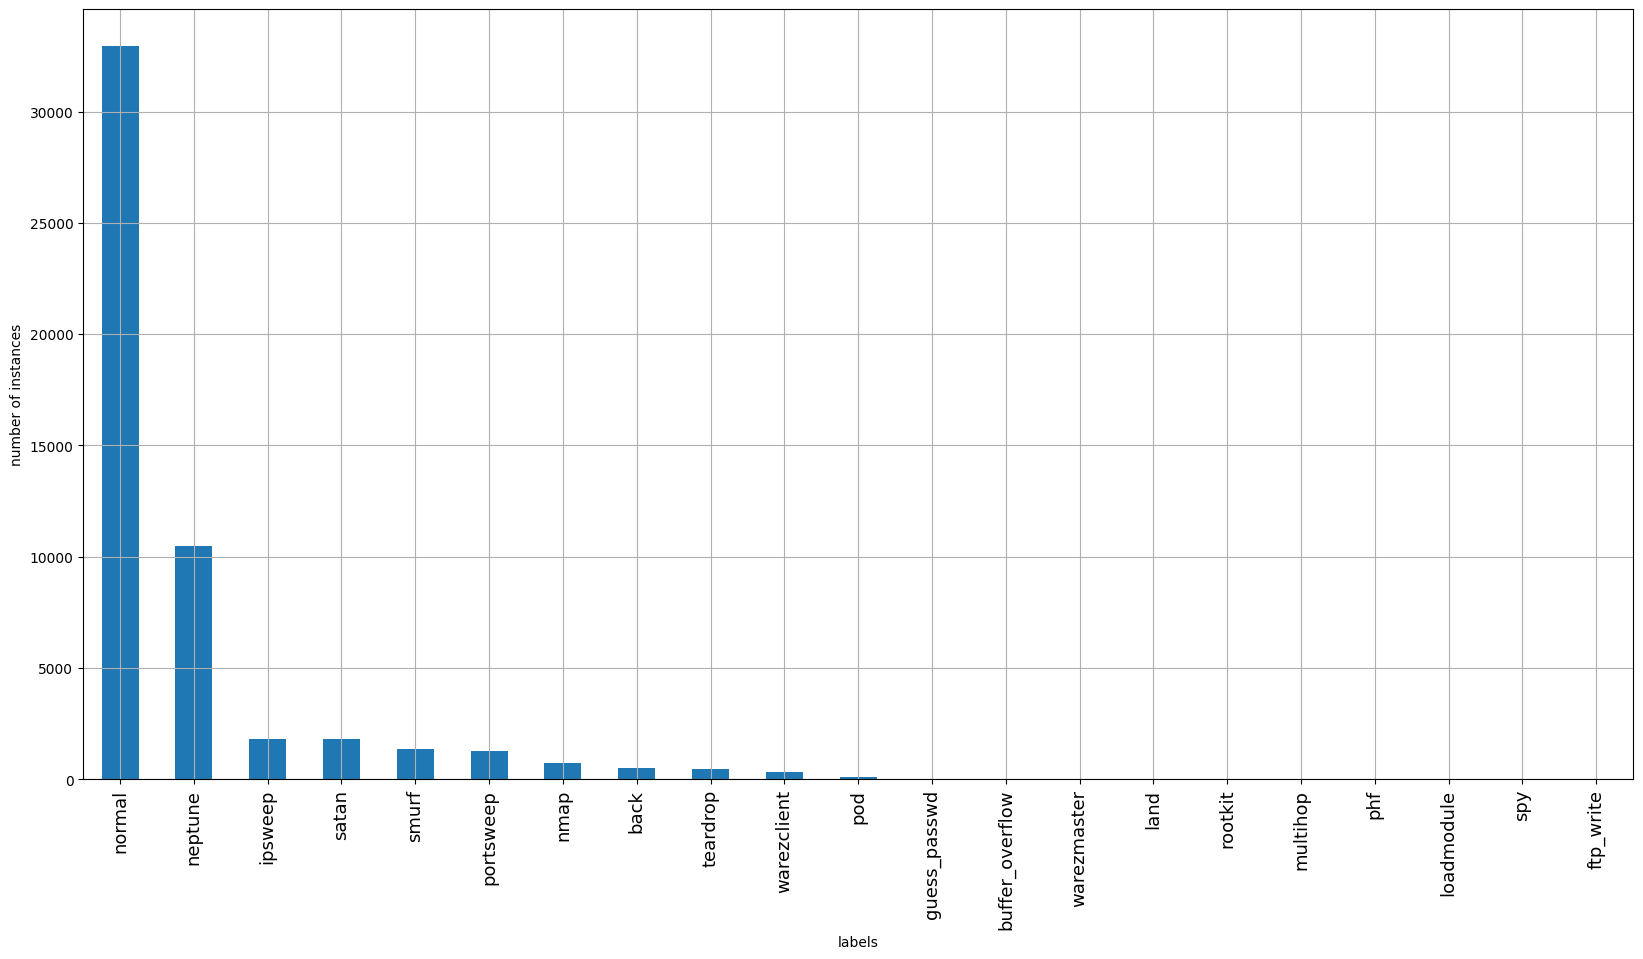

In [16]:
pd.value_counts(df_http['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

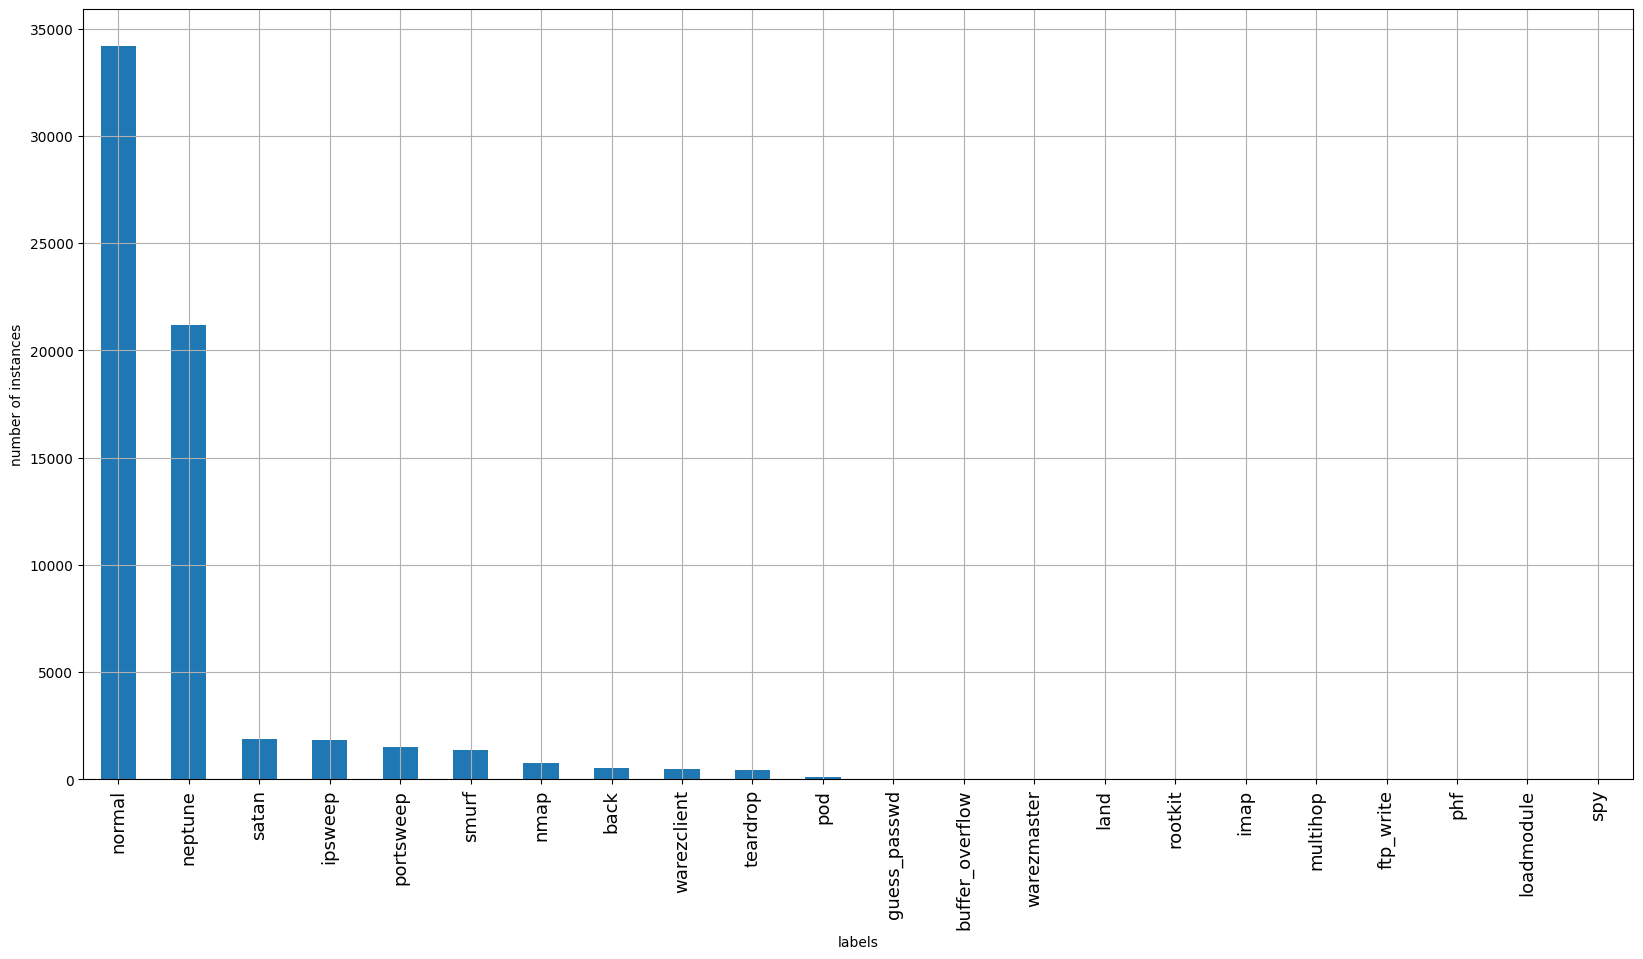

In [17]:
pd.value_counts(df['labels']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [18]:
normal_instances = df_http[df_http['labels']=='normal'].shape[0]
anomalous_instances = df_http[df_http['labels']!='normal'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

32951
18888
percentage of anomalies = 57.32147734514886


In [19]:
df_http_normal = df_http[df_http['labels']=='normal']

In [21]:
df_http_normal.shape

(32951, 42)

In [22]:
# dropping catrgorical columns
df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
# dropping columns with no std deviation
df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

<ipython-input-22-c7b3529d7086>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
<ipython-input-22-c7b3529d7086>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [23]:
df_http_normal.describe()

,duration,src_bytes,dst_bytes,hot,num_compromised,root_shell,num_root,num_shells,num_access_files,count,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,32951.000000,3.295100e+04,3.295100e+04,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,...,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000,32951.000000
mean,156.757215,9.402269e+03,4.068284e+03,0.011441,0.622682,0.002033,0.676854,0.000516,0.007830,23.336196,...,147.446208,196.555886,0.834394,0.039021,0.122675,0.025410,0.014107,0.005987,0.047083,0.043062
std,1248.666214,1.317971e+05,5.998582e+04,0.451156,43.628748,0.045047,44.111492,0.022708,0.131754,55.034725,...,101.892312,88.139430,0.304509,0.128270,0.257282,0.063937,0.093219,0.056472,0.197671,0.188807
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.450000e+02,1.050000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,40.000000,142.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,2.340000e+02,3.800000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,156.000000,255.000000,1.000000,0.000000,0.010000,0.010000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,3.230000e+02,2.014000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,...,255.000000,255.000000,1.000000,0.020000,0.070000,0.030000,0.000000,0.000000,0.000000,0.000000
max,40504.000000,4.357454e+06,5.132416e+06,77.000000,7479.000000,1.000000,7468.000000,1.000000,8.000000,511.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


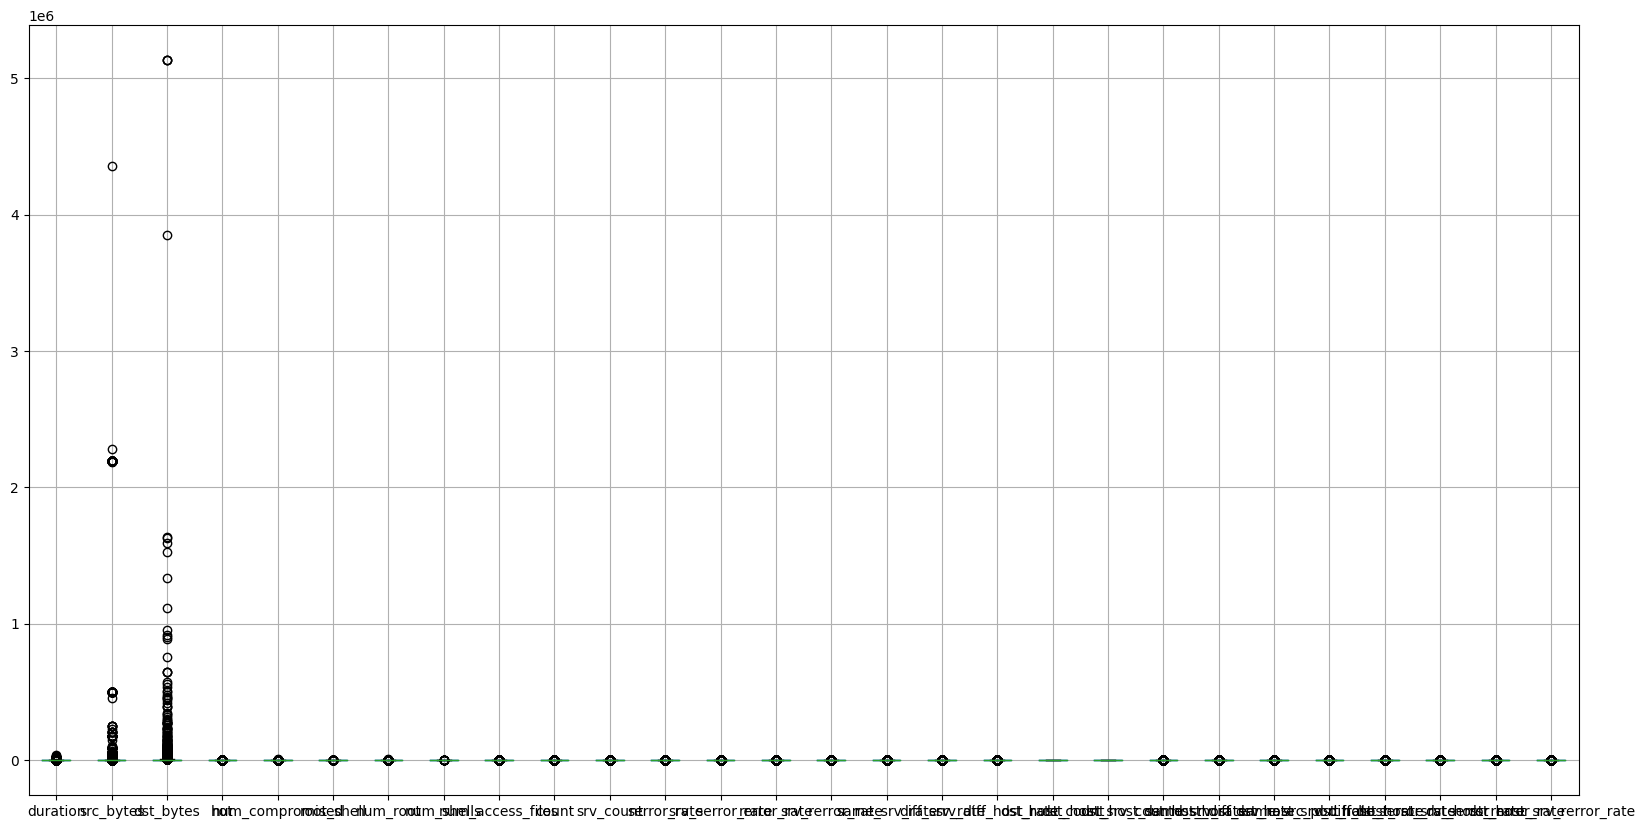

In [24]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [25]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [26]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [27]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [28]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12
0,-0.331229,1.796949,-0.382401,0.039630,0.409730,-0.712131,-0.193096,0.663530,-0.342352,-0.344348,0.000080,0.030476,-0.126670
1,-0.952233,7.007680,-2.403329,2.465798,-0.601445,2.584479,-0.268212,-0.200359,0.337033,0.387428,-0.014262,-0.143981,-0.199285
2,-0.000726,-0.432467,0.613165,-2.678531,-0.916914,0.966948,-1.082726,-0.493731,0.375964,0.166002,0.039173,0.002873,-0.472791
3,-0.771532,-1.029887,0.062713,0.210234,-0.069672,0.142587,0.462664,-0.045108,-0.499142,0.016533,0.018183,0.061417,-0.446030
4,0.095026,-0.507811,0.067308,-0.747582,1.203908,0.067163,-0.244682,-0.053467,0.243524,0.126709,0.034693,-0.212666,0.873955


In [29]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [30]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 3295/3295 [00:00<00:00, 13460.12it/s]


In [31]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [32]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 13), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(13, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                61960     
                                                                 
 decoder (Sequential)        (None, 10, 13)            57173     
                                                                 
Total params: 119133 (465.36 KB)
Trainable params: 119133 (465.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            30080     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 61960 (242.03 KB)
Trainable params: 61960 (242.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
    

(None, None)

In [34]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=100, callbacks=[check_point])

Epoch 1/100
41/42 [============================>.] - ETA: 0s - loss: 0.8470
Epoch 1: val_loss improved from inf to 0.83798, saving model to autoencoder.h5
42/42 [==============================] - 10s 62ms/step - loss: 0.8450 - val_loss: 0.8380
Epoch 2/100
 3/42 [=>............................] - ETA: 1s - loss: 0.7307

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - ETA: 0s - loss: 0.8160
Epoch 2: val_loss improved from 0.83798 to 0.81664, saving model to autoencoder.h5
42/42 [==============================] - 2s 43ms/step - loss: 0.8160 - val_loss: 0.8166
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 0.7988
Epoch 3: val_loss improved from 0.81664 to 0.80070, saving model to autoencoder.h5
42/42 [==============================] - 2s 42ms/step - loss: 0.7978 - val_loss: 0.8007
Epoch 4/100
41/42 [============================>.] - ETA: 0s - loss: 0.7736
Epoch 4: val_loss improved from 0.80070 to 0.78436, saving model to autoencoder.h5
42/42 [==============================] - 2s 42ms/step - loss: 0.7801 - val_loss: 0.7844
Epoch 5/100
41/42 [============================>.] - ETA: 0s - loss: 0.7692
Epoch 5: val_loss improved from 0.78436 to 0.77280, saving model to autoencoder.h5
42/42 [==============================] - 3s 62ms/step - loss: 0.7689 - val_loss: 0.7728
Epoch 6/100
42/42 [=====

In [35]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [36]:
# loading the test dataframe
test_df = pd.read_csv('kdd_test1.csv')
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,5,tcp,smtp,SF,2429,475,0,0,0,0,...,57,0.11,0.02,0.01,0.04,0.0,0.0,0.87,0.0,normal
1,0,udp,domain_u,SF,45,134,0,0,0,0,...,155,0.80,0.02,0.01,0.00,0.0,0.0,0.00,0.0,normal
2,0,udp,domain_u,SF,45,80,0,0,0,0,...,255,1.00,0.00,0.01,0.00,0.0,0.0,0.00,0.0,normal
3,1979,udp,other,SF,145,105,0,0,0,0,...,2,0.01,0.84,1.00,0.00,0.0,0.0,0.00,0.0,normal
4,14462,tcp,other,RSTR,1,0,0,0,0,0,...,2,0.01,0.68,1.00,0.00,0.0,0.0,1.00,1.0,portsweep


In [37]:
# slicing only the rows belonging to http service
test_df_http =   test_df[test_df['service'].isin(selected_services)]

In [38]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='normal' else 1 for i in test_df_http['labels']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [39]:
# dropping catrgorical columns
test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
# dropping columns with no std deviation
test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)

<ipython-input-39-e48dd4a85e10>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'labels'], axis=1, inplace=True)
<ipython-input-39-e48dd4a85e10>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df_http.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'su_attempted', 'num_file_creations', 'num_outbound_cmds'], axis=1, inplace=True)


In [40]:
test_df_http = pd.DataFrame(scaler.transform(test_df_http), columns=test_df_http.columns)

In [41]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12
0,1.603644,1.508697,-0.358343,0.345409,-0.073458,-0.575769,0.251328,0.703560,-0.677508,-0.544458,-0.014814,0.087931,-0.334045
1,-1.535004,-1.404372,-0.102175,2.657356,-3.123279,-0.560040,-0.748784,0.321554,0.514810,-0.323709,-0.065617,-0.182144,1.184342
2,-1.187074,-1.601422,0.053693,1.357838,-1.543495,-0.084660,-0.015013,0.003656,-0.033927,-0.056164,-0.017403,0.000306,0.025626
3,-0.668534,5.945036,-1.105800,1.600114,-0.158312,-2.394428,-2.588625,0.228686,-1.693632,1.065898,0.290636,-0.422506,-1.259855
4,8.587832,7.702723,0.001899,4.589467,-2.835436,-4.388202,-1.511997,-2.111575,-5.012755,2.659821,0.543979,-0.081826,-4.180082


In [42]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

100%|██████████| 1835/1835 [00:00<00:00, 15953.05it/s]


In [43]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

58/58 [==============================] - 1s 10ms/step


In [44]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [45]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [46]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

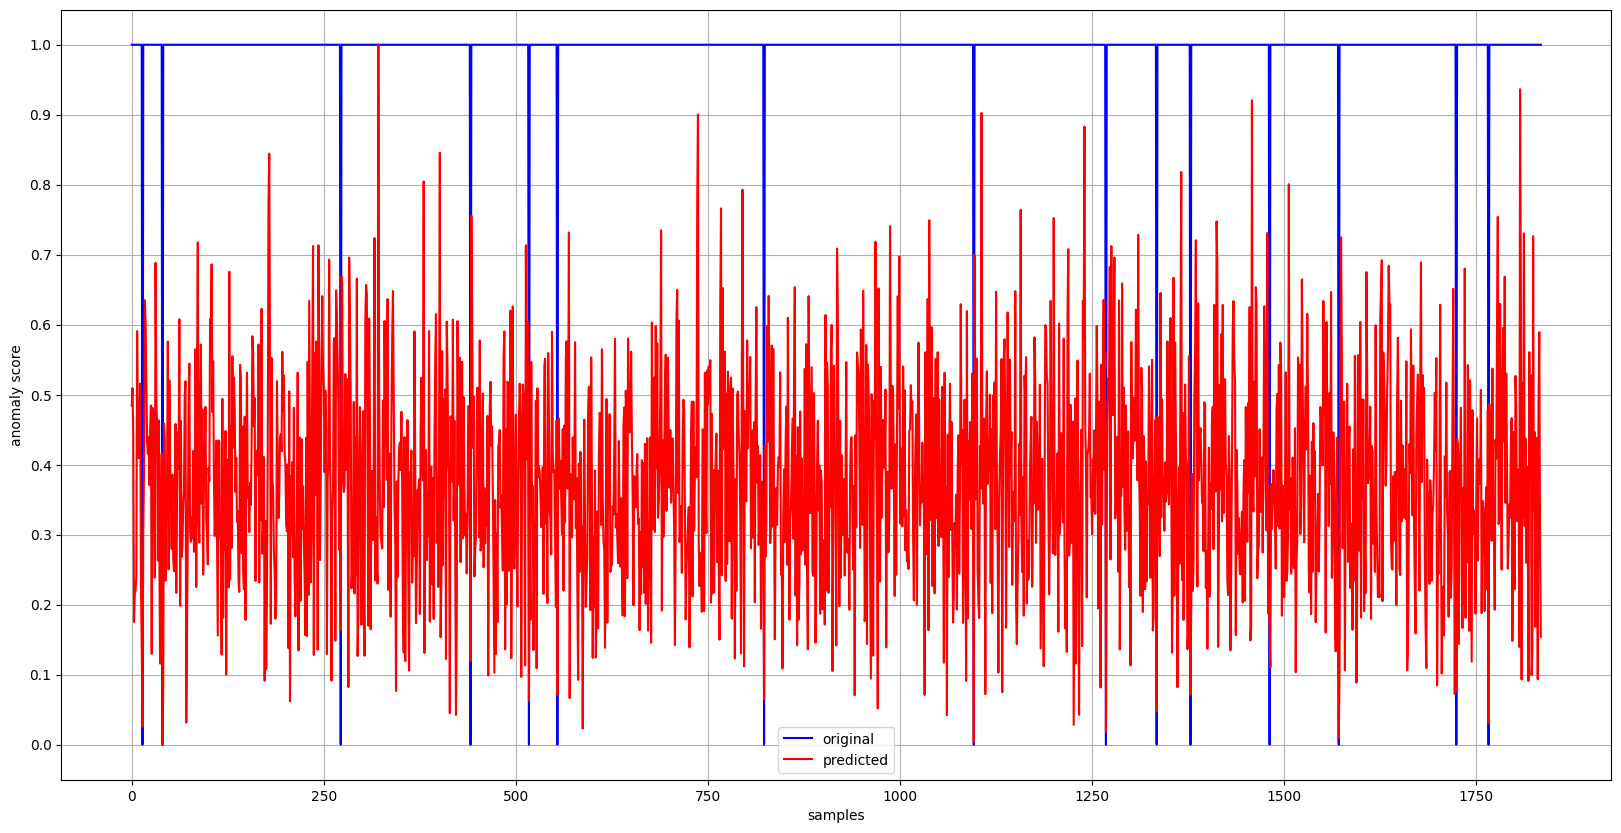

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [48]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [49]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

Area under ROC curve: 0.9861172161172163


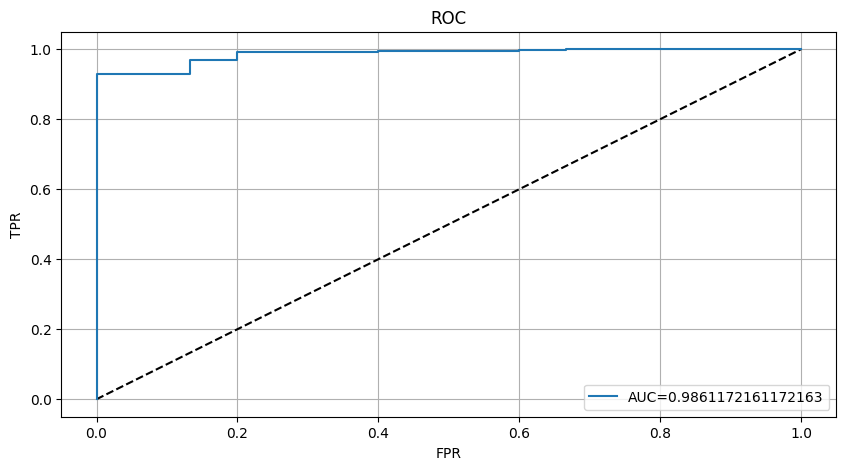

In [50]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [51]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

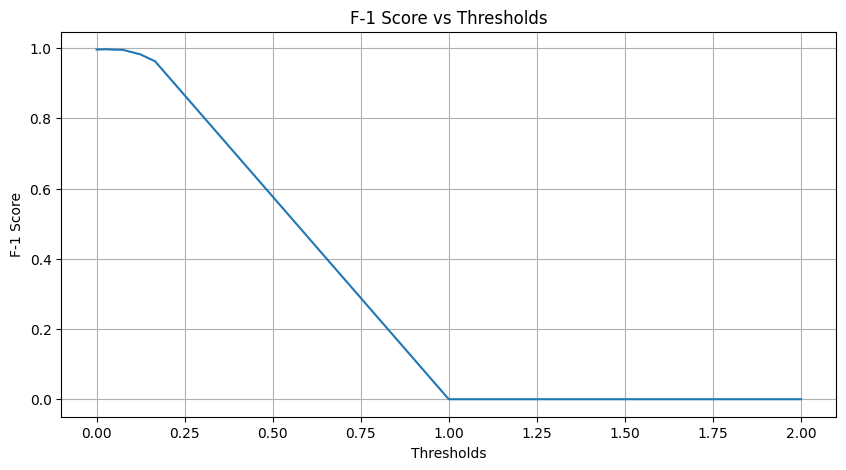

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [53]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

best threshold = 0.025577589869499207


In [54]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [55]:
confusion_matrix(test_labels, anomaly_indicator)

array([[   5,   10],
       [   1, 1819]])

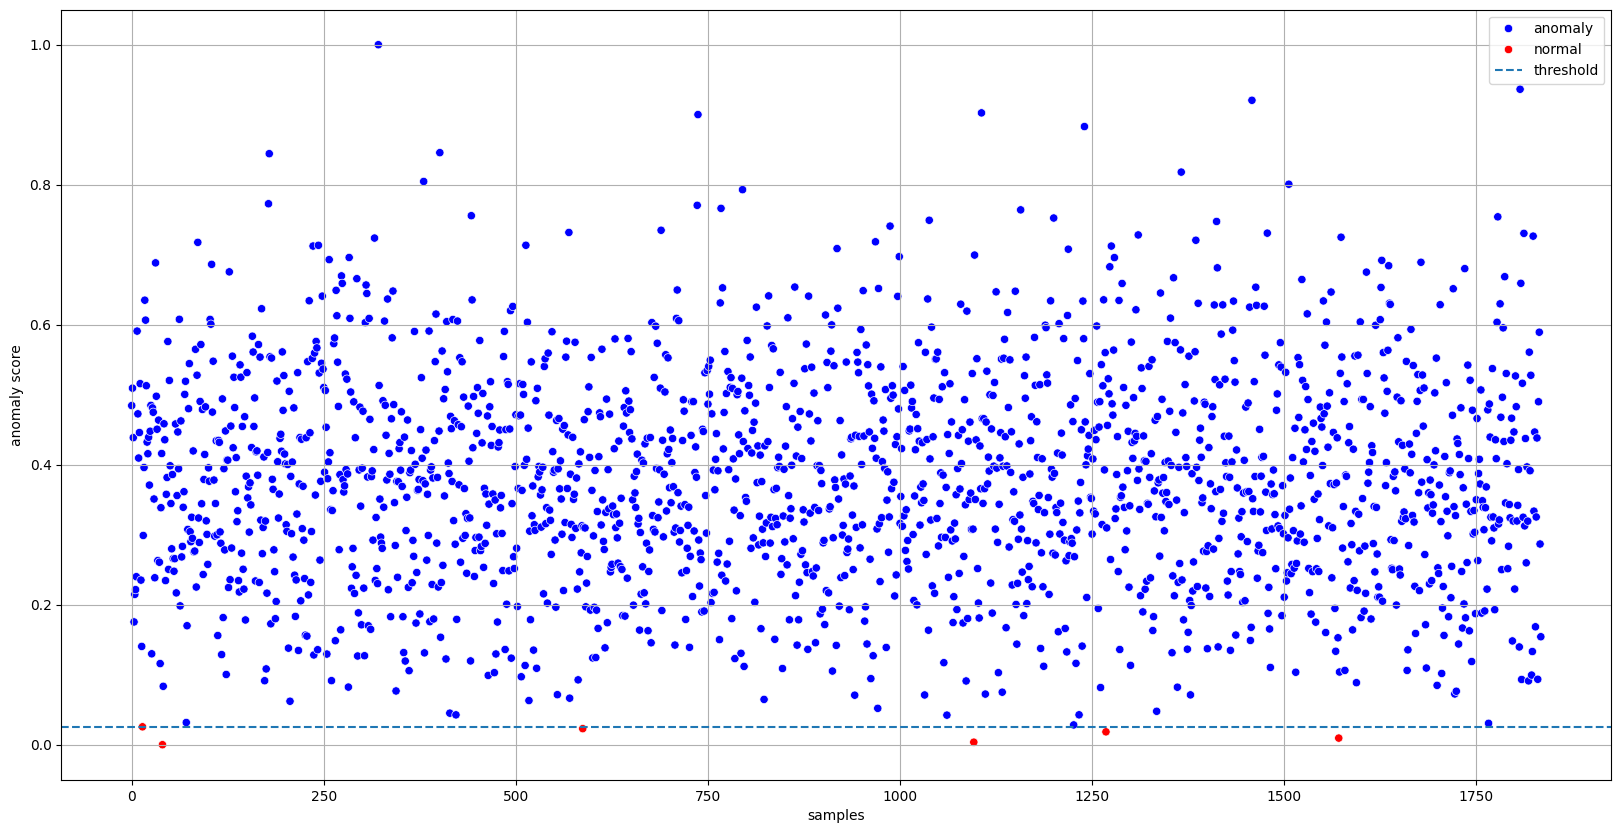

In [56]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [57]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [58]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))

Model has the following classification metrics:
 precision = 0.9945325314379442
 recall = 0.9994505494505495
 f1_score = 0.9969854754727322
 accuracy_score = 0.9940054495912807
